In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

df_train = pd.read_csv("./train.csv/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("./test.csv/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("./macro.csv", parse_dates=['timestamp'])

In [7]:
df_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [8]:
df_test_kremlin_km = df_test["kremlin_km"]
print df_train.full_sq

0         43
1         34
2         43
3         89
4         77
5         67
6         25
7         44
8         42
9         36
10        36
11        38
12        43
13        31
14        31
15        51
16        47
17        42
18        59
19        44
20        74
21        39
22        48
23        32
24        34
25        45
26        35
27        38
28        73
29        42
        ... 
30441    113
30442     40
30443     79
30444     85
30445     47
30446     82
30447     64
30448     74
30449     47
30450     65
30451     37
30452     38
30453     45
30454     40
30455     79
30456     52
30457     58
30458     50
30459     51
30460     54
30461     36
30462     47
30463     56
30464     56
30465     52
30466     44
30467     86
30468     45
30469     64
30470     43
Name: full_sq, dtype: int64


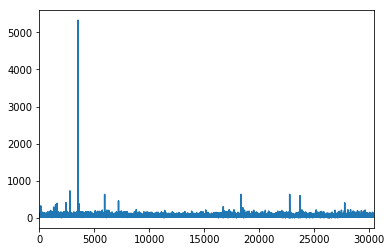

In [17]:
df_train.full_sq.plot()

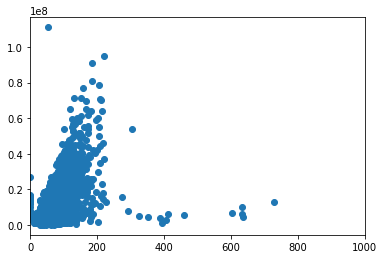

In [19]:
plt.xlim(0,1000)
plt.scatter(df_train["full_sq"],df_train["price_doc"])
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


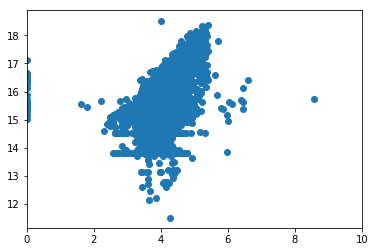

In [23]:
plt.xlim(0,10)
plt.scatter(np.log(df_train["full_sq"]),np.log(df_train["price_doc"]))
plt.show()

In [24]:
# =============================
# =============================
# cleanup
# brings error down a lot by removing extreme price per sqm
print(df_train.shape)
df_train.loc[df_train.full_sq == 0, 'full_sq'] = 30
df_train = df_train[df_train.price_doc/df_train.full_sq <= 600000]
df_train = df_train[df_train.price_doc/df_train.full_sq >= 10000]
print(df_train.shape)
# =============================
# =============================

(30471, 292)
(30404, 292)


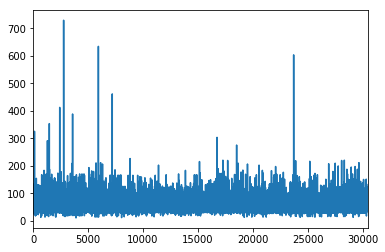

In [25]:
df_train.full_sq.plot()

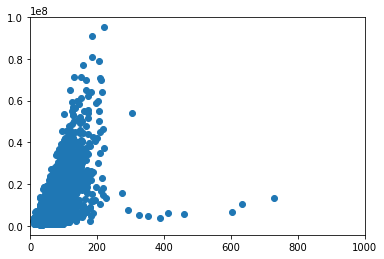

In [26]:
plt.xlim(0,1000)
plt.scatter(df_train["full_sq"],df_train["price_doc"])
plt.show()

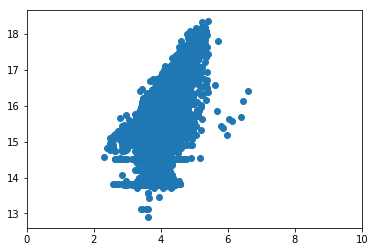

In [27]:
plt.xlim(0,10)
plt.scatter(np.log(df_train["full_sq"]),np.log(df_train["price_doc"]))
plt.show()

In [ ]:
y_train = df_train['price_doc'].values
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = df_all.join(df_macro, on='timestamp', rsuffix='_macro')
print(df_all.shape)


# ==============================
# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)

factorize = lambda t: pd.factorize(t[1])[0]

df_obj = df_all.select_dtypes(include=['object'])

X_all = np.c_[
    df_all.select_dtypes(exclude=['object']).values,
    np.array(list(map(factorize, df_obj.iteritems()))).T
]
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]


# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)


# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]

df_columns = df_values.columns


xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)


# Uncomment to tune XGB `num_boost_rounds`

#cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
#    verbose_eval=True, show_stdv=False)
#cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
#num_boost_rounds = len(cv_result)

num_boost_round = 489

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_round)

fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

y_pred = model.predict(dtest)

# depending on kremlin_km, we adjust prices
#df_test_kremlin_km
#y_pred = np.round(y_pred * 0.98)


df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_sub.to_csv('sub.csv', index=False)